In [1]:
import torchtext
from torchtext.vocab import Vectors, GloVe
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from submission.models import *
from evaluation import *
from submission.helpers import *

In [3]:
# Our input $x$
TEXT = torchtext.data.Field()
    
# Our labels $y$
LABEL = torchtext.data.Field(sequential=False)


train, val, test = torchtext.datasets.SST.splits(
    TEXT, LABEL,
    filter_pred=lambda ex: ex.label != 'neutral')

# Build vocab
TEXT.build_vocab(train)
LABEL.build_vocab(train)

train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits(
(train, val, test), batch_size=50, device=-1, repeat=False)

# Build the vocabulary with word embeddings
url = 'https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.simple.vec'
TEXT.vocab.load_vectors(vectors=Vectors('wiki.simple.vec', url=url))

In [ ]:
# LOGISTIC REGRESSION
model_lr = LogisticRegression(TEXT, LABEL)
trainer = TextTrainer(TEXT, LABEL, model_lr)
trainer.train(train_iter, num_iter=1000, skip_iter=100)

In [3]:
# MULTINOMIAL NAIVE BAYES
model_mnb = MultinomialNB(TEXT, LABEL, bag_or_set='set')
model_mnb.train(train_iter)

0
100


In [4]:
# EVALUATION
print(model_eval(model_mnb, test, test_iter))
# train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits(
#     (train, val, test), batch_size=10, device=-1, repeat=False)
# model_save_predictions(model_mnb, test_iter, predictions_file='predictions-4.txt')

(1496, 1821)


Iteration 0, loss: 1.048220
Iteration 100, loss: 0.331448
Iteration 200, loss: 0.257269
Iteration 300, loss: 0.121578
Iteration 400, loss: 0.459882
Iteration 500, loss: 0.468793
Iteration 600, loss: 0.091529
Iteration 700, loss: 0.115263
Iteration 800, loss: 0.432724
Iteration 900, loss: 0.023642
Iteration 1000, loss: 0.146973
Iteration 1100, loss: 0.106556
Iteration 1200, loss: 0.001832
Iteration 1300, loss: 0.053486
Iteration 1400, loss: 0.094997
Iteration 1500, loss: 0.376548
Iteration 1600, loss: 0.031736
Iteration 1700, loss: 0.153886
Iteration 1800, loss: 0.480524
Iteration 1900, loss: 0.094764
Iteration 2000, loss: 0.054036
Iteration 2100, loss: 0.167741
Iteration 2200, loss: 0.781658
Iteration 2300, loss: 0.323391
Iteration 2400, loss: 0.307176
Iteration 2500, loss: 0.080178
Iteration 2600, loss: 0.133883
Iteration 2700, loss: 0.095422
Iteration 2800, loss: 0.574451
Iteration 2900, loss: 0.092676
Iteration 3000, loss: 0.070559
Iteration 3100, loss: 0.388640
Iteration 3200, loss

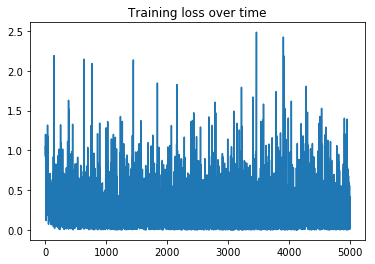

In [5]:
# CONTINUOUS BAG OF WORDS
model_cbow = CBOW(TEXT, LABEL, dynamic=False)
trainer = TextTrainer(TEXT, LABEL, model_cbow)
model_cbow.train()
trainer.train(train_iter, num_iter=5000)

Iteration 0, loss: 1.107660
Iteration 100, loss: 0.690641
Iteration 200, loss: 0.655199
Iteration 300, loss: 0.694694
Iteration 400, loss: 0.594067
Iteration 500, loss: 0.604510
Iteration 600, loss: 0.509097
Iteration 700, loss: 0.562376
Iteration 800, loss: 0.451537
Iteration 900, loss: 0.517283
Iteration 1000, loss: 0.494886
Iteration 1100, loss: 0.367105
Iteration 1200, loss: 0.460856
Iteration 1300, loss: 0.391581
Iteration 1400, loss: 0.357110
Iteration 1500, loss: 0.290865
Iteration 1600, loss: 0.353636
Iteration 1700, loss: 0.360842
Iteration 1800, loss: 0.190142
Iteration 1900, loss: 0.278571
Iteration 2000, loss: 0.224354
Iteration 2100, loss: 0.311734
Iteration 2200, loss: 0.150293
Iteration 2300, loss: 0.236723
Iteration 2400, loss: 0.116120
Iteration 2500, loss: 0.230273
Iteration 2600, loss: 0.260184
Iteration 2700, loss: 0.114305
Iteration 2800, loss: 0.103850
Iteration 2900, loss: 0.199170
Iteration 3000, loss: 0.140034
Iteration 3100, loss: 0.157483
Iteration 3200, loss

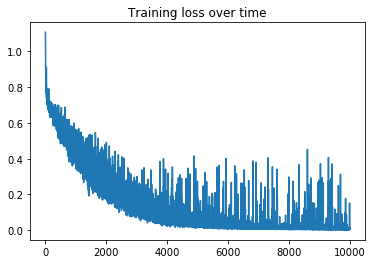

In [4]:
# CONVOLUTIONAL NEURAL NETWORK (can modify do_binary, activation)
model = CNN(TEXT, LABEL, do_binary=False, activation=F.tanh, train_embeddings=False)
trainer = TextTrainer(TEXT, LABEL, model, optimizer=optim.Adadelta)
model.train()
trainer.train(train_iter, num_iter=10000)

In [5]:
# EVALUATION AGAIN
# for i in range(10):
model.eval()
# print
# evaluator = TextEvaluator(model)
# evaluator.score(test_iter)
print(model_eval(model, test, do_binary=False))
# model.train()

(1459, 1821)
